In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt, log

from acquire import acquire_data
from prepare import the_master_imputer, data_prep, percent_of_values_missing, change_data_to_int, change_data_to_object, zillow_single_unit_prop
from set_counties import create_county_cols
from summerize import summarize_data, show_distribution
from preprocessing import split_my_data, scale_data
from model import calculate_logerror, better_than_zillow

# Intro

## Jeremy & David
**Improving Zillow's Logerror**

### Agenda
    1. Summarize our findings verbally among our fellow data scientists 
    2. Go through our notebook and briefly summarize our thought process behind our ideas step-by-step
    3. present our conclusion and what our thoughts are behind solving zillow's zestimate that is wildly broken

### Summary

- In the zillow dataset log error comes from this equation 
> **logerror = log(prediction) - log(actual)**  [Source](https://www.kaggle.com/c/zillow-prize-1/overview/evaluation)
- Our goal was to use different clusters and even some vanilla features in a regression models to beat the already established baseline that is zillow's logerror presented in this dataset
- we used these techniques to predict our own zestimate and then ran that as our prediction variable in the logerror algorithm to equate our own logerror that would be better than the baseline 
- We failed to accomplish our goal, we couldn't find the right features to create a logerror that would beat the zillow baseline logerror.



# Acquire

- using our function from our acquire.py file to import our data from SQL and import it into a csv, drop the Unnamed column and assign it to a data frame
- in our SQL query we decided to eliminate all properties that were not a single unit family residential home
- we also cut some of our outliers by removing any home where their structuretaxvaluedollarcnt was > $1,000,000

In [2]:
df = acquire_data()

Acquiring data ...

- csv already exist

Data has been acquired


# Prepare

**more outlier control**

- this function below, limits our result's to include homes where the unit's square footage is no less than 500 sq ft, no less than 1 bedroom and 1 bathroom, and no greater than 5 bedrooms and 5 bathrooms.

In [3]:
df = zillow_single_unit_prop(df)

- our data_prep function removes any column missing 50% or more of their data as well as any row missing up to 75% of it's data (*We didn't want to waste time strategizing ways to accuratly sum up data missing over 50% of it's values*) 

In [4]:
df = data_prep(df)

- the function below tells us what percent of each column is missing

In [5]:
percent_of_values_missing(df)

parcelid                        0.00
logerror                        0.00
transactiondate                 0.00
bathroomcnt                     0.00
bedroomcnt                      0.00
calculatedfinishedsquarefeet    0.00
fips                            0.00
latitude                        0.00
longitude                       0.00
lotsizesquarefeet               0.60
regionidcity                    1.93
regionidcounty                  0.00
regionidzip                     0.04
yearbuilt                       0.06
structuretaxvaluedollarcnt      0.00
taxvaluedollarcnt               0.00
landtaxvaluedollarcnt           0.00
taxamount                       0.01
dtype: float64

- using the_master_imputer function, we will fill all of our missing functions with the median value, for that column's rows (*Since we weren't missing more than 2% of any data, we felt that the median would suffice for the missing values in our dataset*)

In [6]:
df = the_master_imputer(df)

We see that all of our missing values are taken care of

In [7]:
df.isna().sum()

parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
dtype: int64

>now we're going to take our fips # and use that to impute what county our observations were made in using our create_county_cols function and in the process we're going to drop our fips & our regioncounty columns.
fips source: [THIS LINK](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013697)

In [8]:
df = create_county_cols(df)

### Feature Engineering
- add bed_bath_ratio: which is bathroomcnt / bedroomcnt
- add age: which is 2017 - yearbuilt
- add tax_rate: which is taxamount / taxvaluedollarcnt

In [9]:
df['bed_bath_ratio'] = df['bathroomcnt'] / df['bedroomcnt']

df['age'] = 2017 - df['yearbuilt']

df['tax_rate'] = df['taxamount'] / df['taxvaluedollarcnt']

### Lets change our values so we can have less noise in our exploration / modeling phase

- using our change_data_to_int function to change the datatypes of *yearbuilt*, *latitude*, *longitude*, *lotsizesquarefeet*, *calculatedfinishedsquarefeet*, *fips*, & *bedroomcnt* to change these datatypes from float's to integers to make the data more exclusive

In [10]:
cols = ['yearbuilt', 'latitude', 'longitude', 'lotsizesquarefeet', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'fips' ]
df = change_data_to_int(df, cols)

- using our change_data_to_object function to change the datatypes of *parcelid*, *regionidcity*, *regionidcounty*, *fips* & *regionidzip* to object. (we dont want to do any addition with our unit id's)

In [11]:
cols = ['parcelid', 'regionidzip', 'regionidcity', 'LA', 'Ventura', 'Orange', 'fips', 'regionidcounty']
df = change_data_to_object(df, cols)

### We're going summarize what our data looks like
- this functions runs a .info, a .describe and a .shape on our data and returns it in a pandas series

In [12]:
# uncomment to run function
#summarize_data(df)

## Preprocessing

- using split_my_data function to split our data into train, test and validate data frames

In [13]:
train, test, val = split_my_data(df, .15, .50)

- using scale_data function to scale our data with MinMaxScaler()

In [14]:
train_scaled = train[['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'lotsizesquarefeet']]
train_scaled, scaler = scale_data(train_scaled)
train[['scaled_taxvaluedollarcnt', 'scaled_calculatedfinishedsquarefeet', 'scaled_bedroomcnt', 'scaled_lotsizesquarefeet']] = train_scaled[['taxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'bedroomcnt', 'lotsizesquarefeet']]

# Exploration

- Perform clustering with logerror, longitude & latitude

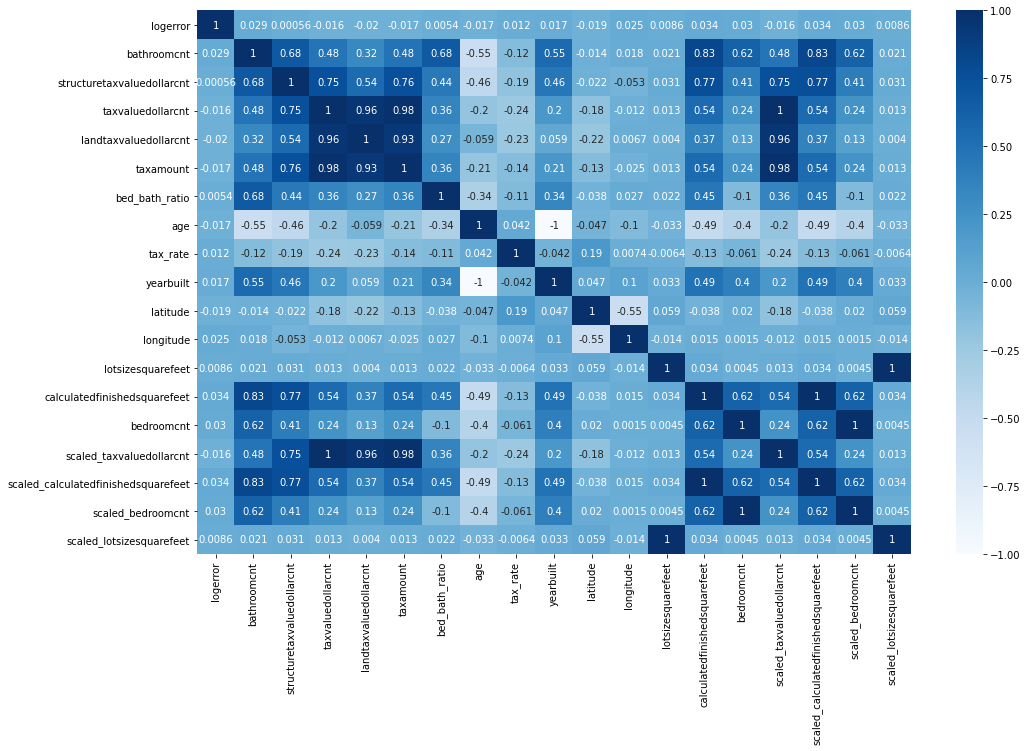

In [15]:
# Overall correlation of the features and the target.
plt.figure(figsize=(16,10))
sns.heatmap(train.corr(), cmap='Blues', annot=True)

In [16]:
X = train[['logerror', 'longitude', 'latitude']]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['log_cluster'] = kmeans.predict(X)

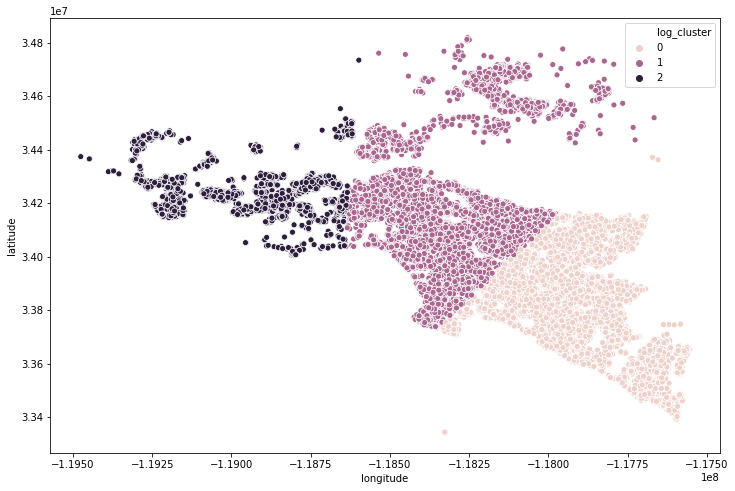

In [17]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='longitude', y='latitude' , hue='log_cluster', data=train)

- 3 distinct clusters of areas found using longitude and latitude
- lets find out if they're correlated with our counties by visualizing our longitude, latitude and hue it by county

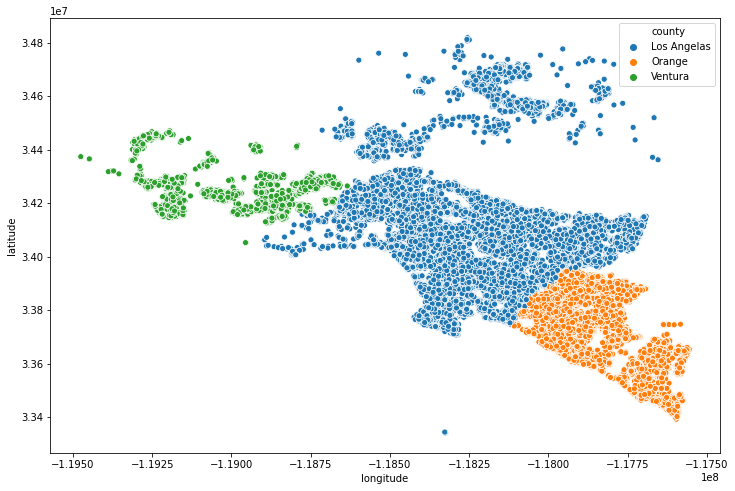

In [18]:
plt.figure(figsize=(12,8))
sns.scatterplot('longitude', 'latitude', hue='county', data=train)

- visually looks incredibly similar.
- tells us that their logerror algorithm is dependent on where a home is located 

In [19]:
X = train[['logerror','scaled_calculatedfinishedsquarefeet' ]]

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

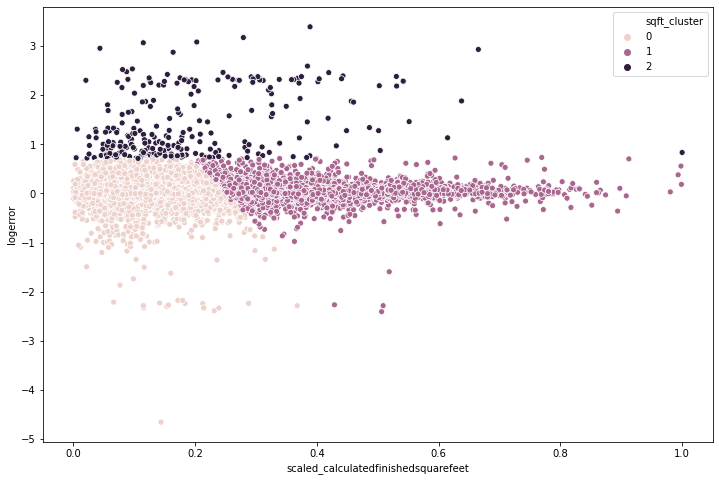

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

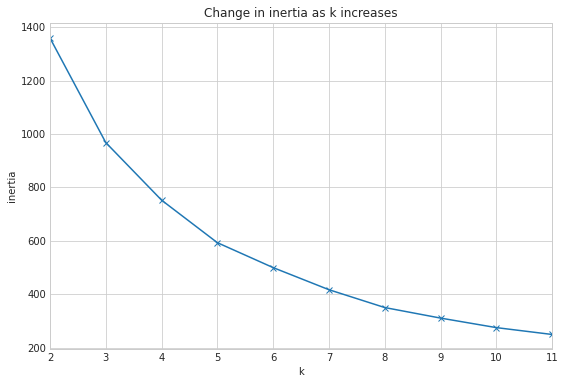

In [21]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

- looks like the optimal k value would be about 5

In [22]:
X = train[['logerror', 'scaled_calculatedfinishedsquarefeet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['sqft_cluster'] = kmeans.predict(X)

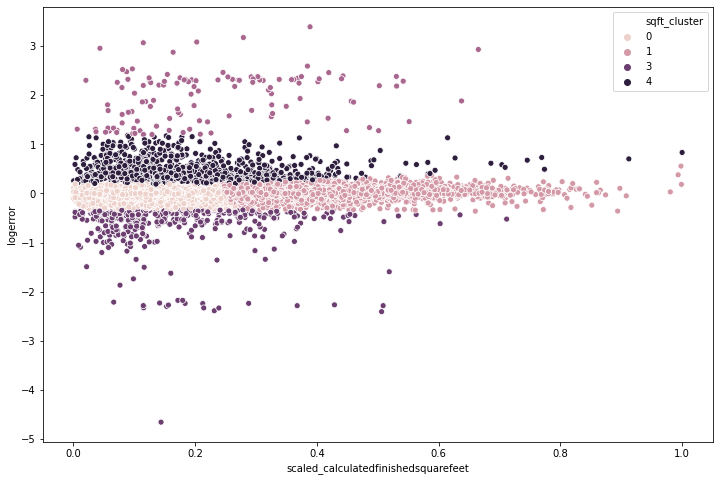

In [23]:
plt.figure(figsize=(12,8))
sns.scatterplot('scaled_calculatedfinishedsquarefeet', 'logerror', hue='sqft_cluster', data=train)

In [24]:
X = train[['logerror', 'scaled_taxvaluedollarcnt', 'scaled_bedroomcnt']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
kmeans.predict(X)

train['money_bed_cluster'] = kmeans.predict(X)

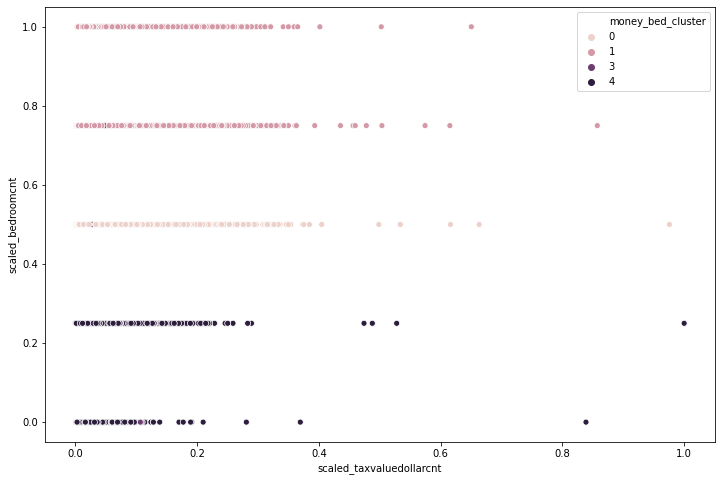

In [25]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='scaled_taxvaluedollarcnt', y='scaled_bedroomcnt', hue='money_bed_cluster', data=train)

In [26]:
X = train[['logerror', 'yearbuilt']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['yearbuilt_cluster'] = kmeans.predict(X)

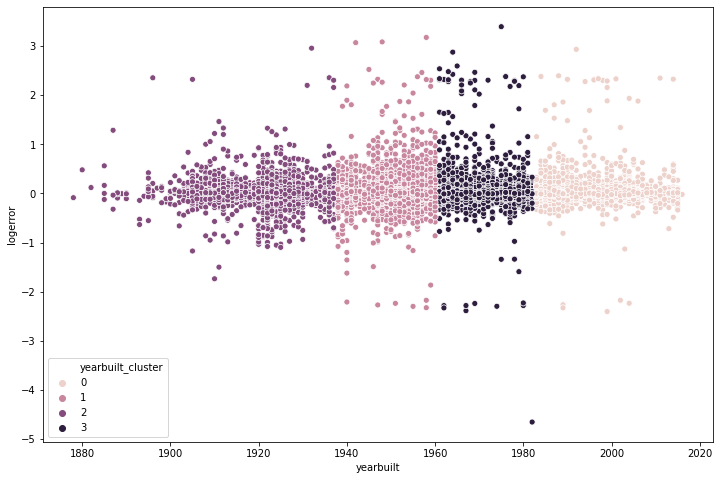

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot('yearbuilt', 'logerror', hue='yearbuilt_cluster', data=train)

In [28]:
X = train[['logerror', 'bed_bath_ratio']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['bed_bath_ratio_cluster'] = kmeans.predict(X)

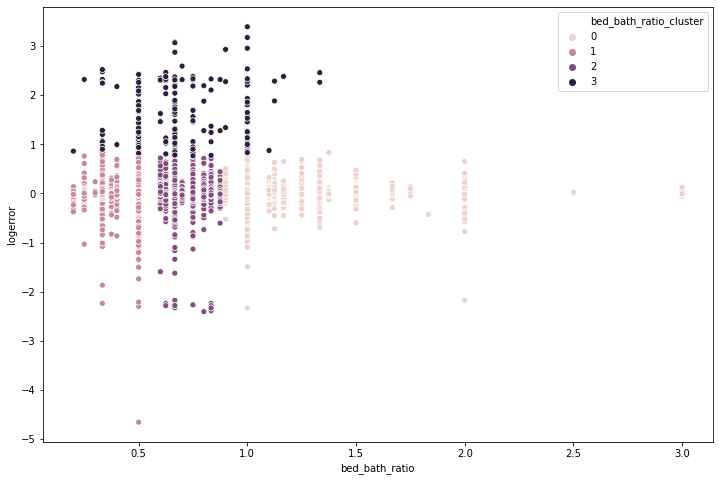

In [29]:
plt.figure(figsize=(12,8))
sns.scatterplot('bed_bath_ratio', 'logerror', hue='bed_bath_ratio_cluster', data=train)

In [30]:
X = train[['logerror', 'tax_rate']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['tax_rate_cluster'] = kmeans.predict(X)

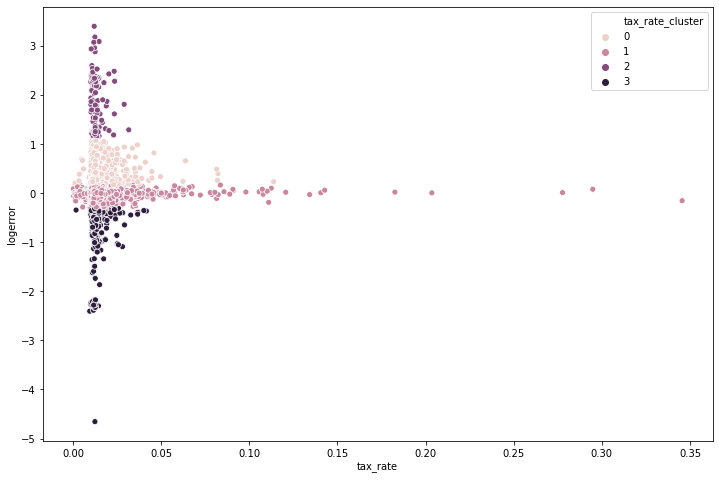

In [31]:
plt.figure(figsize=(12,8))
sns.scatterplot('tax_rate', 'logerror', hue='tax_rate_cluster', data=train)

In [32]:
X = train[['logerror', 'scaled_lotsizesquarefeet']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
kmeans.predict(X)

train['lotsizesquarefeet_cluster'] = kmeans.predict(X)

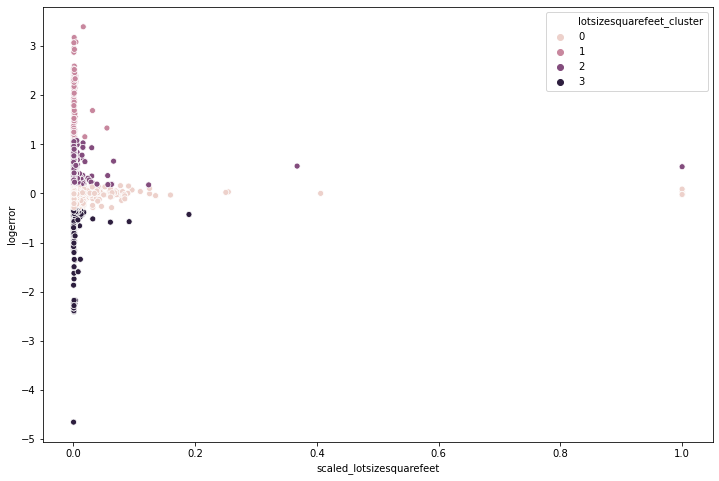

In [33]:
plt.figure(figsize=(12,8))
sns.scatterplot('scaled_lotsizesquarefeet', 'logerror', hue='lotsizesquarefeet_cluster', data=train)

# Modeling

- We used a *linear regression* algorithm to predict taxvalurdollarcnt
- The data used have been all of our features and specified clusters

#### encode the county column

In [34]:
# run this function
def encode(train, test, col_name):
    from sklearn.preprocessing import LabelEncoder
    
    # Integer Encoding
    int_encoder = LabelEncoder()
    train[col_name] = int_encoder.fit_transform(train[col_name])
    test[col_name] = int_encoder.transform(test[col_name])
    
    return train, test

In [35]:
train, val = encode(train, val, 'county')

#### split our train and validate data sets in X_train,and X_val's
- We're using county, # of bathrooms and bedroom and calculated square feet as our features and we're predicting taxvaluedollarcnt as our predictor 

In [36]:
X_train = train[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet', 'age', 'tax_rate']]
y_train = train[['taxvaluedollarcnt']]
X_val = val[['county','bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet', 'age', 'tax_rate']]
y_val = val[['taxvaluedollarcnt']]

#### create the baseline model
- we created a new dataframe called predictions where we used the mean of taxvalue as our baseline the values of taxvalurdollarcnt as our actual

In [37]:
predictions = pd.DataFrame()
predictions['actual'] = y_train['taxvaluedollarcnt']
predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

#### Create our model

In [38]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

#### Evaluate our model
- used RMSE R2 score as evaluators of our model

In [39]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)
# add our predictions to our predictions dataframe
predictions['prediction'] = y_train_pred

In [40]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 356561.39006758324
R2 of training set is 0.3510308447939424
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 365416.4834417069
R2 of validation set is 0.29841923317964114


#### Evaluating our predictions 
- Is our logerror better than zillows logerror?
- we have a function that gives us the absolute sum of zillows logerror subtracted from our proprietary logerror and then divides that by the len of zillow's log error to give us a jerry rigged version of a mean absolute error.

In [41]:
lm_df = calculate_logerror('actual', 'prediction', predictions)
lm_df['zillow_logerror'] = train['logerror']
lm_df['mae_sum'] = abs(lm_df['zillow_logerror'] - lm_df['logerror'])
lm_df['mae'] = lm_df['mae_sum'] / len(lm_df['zillow_logerror'])

In [42]:
lm_df.head()

,actual,baseline,prediction,logerror,zillow_logerror,mae_sum,mae
3147,12.237363,468000.126863,12.433729,0.196366,0.041543,0.154822,0.000004
9831,13.444051,468000.126863,12.825687,-0.618364,-0.086821,0.531543,0.000012
37321,13.344511,468000.126863,12.904730,-0.439781,0.037711,0.477493,0.000011
41583,13.428376,468000.126863,13.257662,-0.170714,0.019999,0.190713,0.000004
32287,13.466706,468000.126863,13.017465,-0.449241,0.026711,0.475951,0.000011


#### Then we realized that wasn't really telling us that our proprietary logerror was in any way shape or form better than zillows...

#### So, we did what all great data scientists do...we created another function...
- we created a function where we calculate the absolute sum of our predicted logerror and zillows logerror and if our logerror is closer to 0 than zillows logerror it gives us a True value, if not a false value. We take the sum of those rows and that gives us a percentage of how often our proprietary logerror beats zillows logerror

In [43]:
better_than_zillow(lm_df.zillow_logerror, lm_df.logerror)

0.07497848787181097

## our proprietary logerror beat zillows logerror 7% of the time

### model by county
- Now we're going by our findings in our first cluster to use county as a filter for our data to see if that model would predict a logerror better than zillows

In [44]:
la_train = train[train.LA == 1]
orange_train = train[train.Orange == 1]
ventura_train = train[train.Ventura == 1]

la_test = test[test.LA == 1]
orange_test = test[test.Orange == 1]
ventura_test = test[test.Ventura == 1]

la_val = val[val.LA == 1]
orange_val = val[val.Orange == 1]
ventura_val = val[val.Ventura == 1]

#### LA model
- features used, *bathroomcnt*, *bedroomcnt*, *calculatedfinishedsquarefeet*, & *lotsizesquarefeet*
- also using a linear regression model

In [45]:
X_train = la_train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = la_train[['taxvaluedollarcnt']]
X_val = la_val[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = la_val[['taxvaluedollarcnt']]

#### create the baseline model
- we created a new dataframe called predictions where we used the mean of taxvalue as our baseline the values of taxvalurdollarcnt as our actual

In [46]:
la_predictions = pd.DataFrame()
la_predictions['actual'] = y_train['taxvaluedollarcnt']

la_predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

#### Create our model

In [47]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

#### Evaluate our model
- used RMSE R2 score as evaluators of our model

In [48]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)
# add our predictions to our predictions dataframe
la_predictions['prediction'] = y_train_pred

In [49]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 377157.2255889316
R2 of training set is 0.26082892031865224
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 346055.6109408906
R2 of validation set is 0.27761976162229196


#### Evaluating our predictions 
- Is our logerror better than zillows logerror?
- we have a function that gives us the absolute sum of zillows logerror subtracted from our proprietary logerror and then divides that by the len of zillow's log error to give us a jerry rigged version of a mean absolute error.

In [50]:
la_lm = calculate_logerror('actual', 'prediction', la_predictions)
la_lm['zillow_logerror'] = la_train['logerror']

la_lm['mae_sum'] = abs(la_lm['zillow_logerror'] - la_lm['logerror'])

la_lm['mae'] = la_lm['mae_sum'] / len(la_lm['zillow_logerror'])

### how often did we beat zillows logerror in LA county?

In [51]:
better_than_zillow(la_lm.zillow_logerror, la_lm.logerror)

0.06671950428705238

## We beat zillow **7%** of the time

#### Ventura model
- features used, *bathroomcnt*, *bedroomcnt*, *calculatedfinishedsquarefeet*, & *lotsizesquarefeet*
- also using a linear regression model

In [52]:
X_train = ventura_train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = ventura_train[['taxvaluedollarcnt']]
X_val = ventura_val[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = ventura_val[['taxvaluedollarcnt']]

#### create the baseline model
- we created a new dataframe called predictions where we used the mean of taxvalue as our baseline the values of taxvalurdollarcnt as our actual

In [53]:
ven_predictions = pd.DataFrame()
ven_predictions['actual'] = y_train['taxvaluedollarcnt']

ven_predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

#### Create our model

In [54]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

#### Evaluate our model
- used RMSE R2 score as evaluators of our model

In [55]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

In [56]:
ven_predictions['prediction'] = y_train_pred

In [57]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 220269.40145240093
R2 of training set is 0.5428436463185909
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 205234.0799548425
R2 of validation set is 0.5094177568601064


#### Evaluating our predictions 
- Is our logerror better than zillows logerror?
- we have a function that gives us the absolute sum of zillows logerror subtracted from our proprietary logerror and then divides that by the len of zillow's log error to give us a jerry rigged version of a mean absolute error.

In [58]:
ven_lm = calculate_logerror('actual', 'prediction', ven_predictions)

ven_lm['zillow_logerror'] = ventura_train['logerror']

ven_lm['mae_sum'] = abs(ven_lm['zillow_logerror'] - ven_lm['logerror'])

ven_lm['mae'] = ven_lm['mae_sum'] / len(ven_lm['zillow_logerror'])

### how often did we beat zillows logerror in Ventura county?

In [79]:
better_than_zillow(ven_lm.zillow_logerror, ven_lm.logerror)

0.07698698421489893

## We beat zillow **8%** of the time

## Orange County model
- features used, *bathroomcnt*, *bedroomcnt*, *calculatedfinishedsquarefeet*, & *lotsizesquarefeet*
- also using a linear regression model

In [69]:
X_train = orange_train[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_train = orange_train[['taxvaluedollarcnt']]
X_val = orange_val[['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet','lotsizesquarefeet']]
y_val = orange_val[['taxvaluedollarcnt']]

#### create the baseline model
- we created a new dataframe called predictions where we used the mean of taxvalue as our baseline the values of taxvalurdollarcnt as our actual

In [70]:
or_predictions = pd.DataFrame()
or_predictions['actual'] = y_train['taxvaluedollarcnt']

or_predictions['baseline'] = y_train.taxvaluedollarcnt.mean()

#### Create our model

In [71]:
# initalize our object
lm = LinearRegression()
# fit our data
lm.fit(X_train, y_train)
# storing our predictions in this dataframe
y_train_pred = lm.predict(X_train)

#### Evaluate our model
- used RMSE R2 score as evaluators of our model

In [72]:
rmse_train = sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_pred_val = lm.predict(X_val)

rmse_val = sqrt(mean_squared_error(y_val, y_pred_val))
r2_val = r2_score(y_val, y_pred_val)

In [73]:
or_predictions['prediction'] = y_train_pred

In [74]:
print("The model performance for the training set")
print("-------------------------------------------")
print(f"RMSE of training set is {rmse_train}")
print(f"R2 of training set is {r2_train}")
print("-------------------------------------------")
print("The model performance for the test set")
print("-------------------------------------------")
print(f"RMSE of validation set is {rmse_val}")
print(f"R2 of validation set is {r2_val}")

The model performance for the training set
-------------------------------------------
RMSE of training set is 369442.9470454493
R2 of training set is 0.38005630001314716
-------------------------------------------
The model performance for the test set
-------------------------------------------
RMSE of validation set is 430190.9033805385
R2 of validation set is 0.31507278817651885


#### Evaluating our predictions 
- Is our logerror better than zillows logerror?
- we have a function that gives us the absolute sum of zillows logerror subtracted from our proprietary logerror and then divides that by the len of zillow's log error to give us a jerry rigged version of a mean absolute error.

In [75]:
or_lm = calculate_logerror('actual', 'prediction', or_predictions)

In [76]:
or_lm['zillow_logerror'] = orange_train['logerror']

or_lm['mae_sum'] = abs(or_lm['zillow_logerror'] - or_lm['logerror'])

or_lm['mae'] = or_lm['mae_sum'] / len(or_lm['zillow_logerror'])

### how often did we beat zillows logerror in Orange county?

In [78]:
better_than_zillow(or_lm.zillow_logerror, or_lm.logerror)

0.07721410146173689

## We beat zillow **8%** of the time

## Conclusion

- we couldn't beat zillows logerror...
- Our best model only did better than 8% of the time...

>Zillows logerror is superior to our proprietary dynamic JD consulting logerror

# Reccommendations

- Develop more features by focusing more on feature engineering
- focus less on correlation of values used in modeling and more on finding clusters and modeling on those